# Basic Machine Learning on 2015 World Teams Championship

1. [Import data](#import)  
    1.1 [Prepare for import data](#import)  
    1.2 [Download data](#download)  
    
    
2. [Clean data](#clean)  
    2.1 [Extract](#clean)  
    2.2 [Split data to dataframs](#split)  
    2.3 [Data first view](#check)  
    2.4 [Join dataframe](#join)  
    2.5 [Split bid to columns](#bid)  
    2.6 [Create useful columns](#HCP)  
    
    - 2.6.1 [HCP columns](#HCP)  
    - 2.6.2 [Game Type column](#type)  
    - 2.6.3 [Declar HCP](#d_HCP)  
    - 2.6.4 [Trump fit](#fit)  
    
  2.7 [Cleaned data view](#cleaned)  


3. [Machine Learning](#ml)  
    [3.1 First regression model: only with declear hand](#m1)  
    [3.2 Model with dummies' hands](#m2)  
    [3.3 Model in Practical](#m3)
    

## 1. Import data
<a id="import"></a>

### 1.1 Prepare for import data

In [1]:
# import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor, sqrt
import time

# Machine learning modules
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split


In [2]:
# runtime check
start_time = time.time()


# Prepare for download the data

# Specify url of 2015 World Teams Championship
url = 'http://www.sarantakos.com/bridge/vugraph/2015/2015-wbc.html'

# Package the request, send the request and catch the response: r
r = requests.get(url)
 
# Extracts the response as html: html_doc
html_doc = r.text
 
# create a BeautifulSoup object from the HTML: soup
soup = BeautifulSoup(html_doc)

# Find all 'a' tags (which define hyperlinks): a_tags
a_tags = soup.find_all('a')

# Initialize a list to store the lin file list 
# lin file is a bridge hand file can be read into BBO
url_list = []

# get urls from a_tags
for link in a_tags:
    url_list.append(link.get('href'))

# If file not end with ''.lin', then remove it from the original list
# Add full path to the file
fullpath = 'http://www.sarantakos.com/bridge/vugraph/2015/'
url_list = [fullpath + linfile for linfile in url_list if bool(re.search('\.lin$', str(linfile)))]

### 1.2 Download data
<a id="download"></a>

In [3]:
# Download the files from url_list and store them into row data
row_data = []

for url in url_list:
    row_data.append(requests.get(url).text)


## 2. Clean data
<a id="clean"></a>

### 2.1 Extract

In [4]:
# Use regular expression to extract the rows we are interested
p1 = 'qx.*\|p\|mb\|p\|mb\|p\|' # Hands and biddings
p2 = 'vg\|.*\|' # Name of the match
p3 = 'rs\|.*\|' # Results
p4 = 'pn\|.*\|' # Players
pattern1 = re.compile("(%s|%s|%s|%s)" % (p1, p2, p3, p4))

# Initialize a list to store the data we are interested in
data_of_interested = []

for data in row_data:
    data_of_interested.append(re.findall(pattern1, data))

In [5]:
# Use regular expression to replace unmeaningful words 1

# Initialize a list to store the data with this replace = clean
clean1_data = []
clean2_data = []
clean3_data = []
clean4_data = []
clean5_data = []

# The patterns
p5 = 'qx\|'
p6 = 'st\|\|md\|'
p7 = 'sv\|'
p8 = 'mb\|'
p9 = 'vg\|'
p10 = 'rs\|'
p11 = 'pn\|'
p12 = '\|pg\|\|'
p13 = '!'
p14 = '\|$'
pattern2 = re.compile("(%s|%s|%s|%s|%s|%s|%s|%s|%s|%s)" % (p5, p6, p7, p8, p9, p10, p11, p12, p13, p14))

# Replace pattern2 to ''
for i, data in enumerate(data_of_interested):
    clean1_data.append([re.sub(pattern2, '', x) for x in data_of_interested[i]])

# Replace the first 3 '|' to ','
for i, data in enumerate(clean1_data):
    clean2_data.append([re.sub('\|', ',', x, 3) for x in clean1_data[i]])

# Replace the rest  '|' with ''
for i, data in enumerate(clean2_data):
    clean3_data.append([re.sub('\|', '', x) for x in clean2_data[i]])
    
# Add a comma between 3 and S in 'o1,3S'
for i, data in enumerate(clean3_data):
    clean4_data.append([re.sub(r'([oc]\d*,\d)', r'\1,', x, 1) for x in clean3_data[i]])

# Add id for each file in clean4_data
for i, data in enumerate(clean4_data):
    clean5_data.append([re.sub(r'^', str(i)+',', x) for x in clean4_data[i]])

### 2.2 Split data to dataframs
<a id="split"></a>

In [6]:
# Split data into 3 parts
# Part 1: All rows expect row1 and row3, this is the play data
bid_data = [row[1:2] for row in clean5_data]
game_data = [row[3:] for row in clean5_data]

# Part 2: row1, game meta-info
info_data = [row[0:1] for row in clean5_data]

# Part 3: row3, player name
player_data = [row[2:3] for row in clean5_data]

In [7]:
# Unpack 2D list to 1D list
info_data = [row for lists in info_data for row in lists]
bid_data = [row for lists in bid_data for row in lists]
player_data = [row for lists in player_data for row in lists]
game_data = [row for lists in game_data for row in lists]

In [8]:
# Create df for each data
info_data_df = pd.DataFrame([line.split(",") for line in info_data])
bid_data_df = pd.DataFrame([line.split(",") for line in bid_data])
player_data_df = pd.DataFrame([line.split(",") for line in player_data])
game_data_df = pd.DataFrame([line.split(",") for line in game_data])

### 2.3 Data first view
<a id="check"></a>

In [9]:
# Add column name
info_data_df.columns = ['match_id', 'match_name', 'session', 'session_No',
                        'start_board', 'end_board', 'Team1', 'Team1_score',
                        'Team2', 'Team2_score']

# Get an idea of what the df look like
info_data_df.head()

,match_id,match_name,session,session_No,start_board,end_board,Team1,Team1_score,Team2,Team2_score
0,0,BBO6-2015WBTC-BB,RR1,I,1,16,CHINA,0,FRANCE,0
1,1,BBO3-2015 WBTC-BB,RR1,I,1,16,DENMARK,0,USA-2,0
2,2,BBO4-2015WBTC-BB,RR1,I,1,16,EGYPT,0,AUSTRALIA,0
3,3,BBO1-2015WBTC-BB,RR1,I,1,16,ENGLAND,0,INDIA,0
4,4,BBO2-2015WBTC-BB,RR1,I,1,16,USA-1,0,ARGENTINA,0


In [10]:
# Get an idea of what the df look like
bid_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,4HE-1,4HE-1,4HS+2,6HS=,3NN+3,3NS+1,3NW+1,3NE+1,4HW+1,...,4SN-1,4SN-2,2HE+1,2HE+2,1NE+2,3NE+1,3HS=,2HS+1,3NE-2,3NEx-2
1,1,3NE-2,4HE-1,6HS=,4HS+2,3NN+1,3NS+1,3NW+1,3NE=,4HE+1,...,4SN-1,4SN-2,2HE+1,2HE+1,3NE-1,3NE=,2HS+1,3DWx-3,3DE=,1NE+1
2,2,3NE-2,4HW-1,4HS+2,4HS+2,3NN+2,3NN-1,3NW+1,3NW+1,4HE+1,...,4SN-2,4SN-1,1SE+1,2DE+1,3NE=,3NE+1,3HS=,2SE-3,1NE+2,3NE-1
3,3,4HE-1,4HE=,6HS=,6HS=,3NN+2,3NS+1,3NW=,3NW+2,4HW+2,...,4SS-1,4SN-1,2HE+1,2HE=,3NE+1,3NE+1,2HS+1,3HS-1,1NE+2,3NE+1
4,4,3NE-2,3NE=,6HN+1,4HS+2,3NS+1,3NS+2,3NW+1,3NW=,4HW+1,...,4SN=,4SN-1,2HE+2,2HE+2,3NE-3,3NE+1,3HS+1,2HS=,3NE-1,3NE+1


In [11]:
# Add column name
player_data_df.columns = ['match_id', 
                          'Player1', 'Player2', 'Player3', 'Player4',
                          'Player5', 'Player6', 'Player7', 'Player8']
# Get an idea of what the df look like
player_data_df.head()

,match_id,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8
0,0,HU,COMBESCURE,LI,ROMBAUT,VOLCKER,SUN,BESSIS,KANG
1,1,CHRISTIANS,DEMUY,SCHALTZ,KRANYAK,WOOLDRIDGE,ASKGAARD,HURD,KONOW
2,2,RAMADAN,COURTNEY,NOSHY,WYER,GRIFFITHS,SADEK,MILNE,NABIL
3,3,HACKETT,ROY,HACKETT,BANERJEE,MANNA,ROBSON,MAJUMDER,FORRESTER
4,4,KATZ,PELLEGRINI,NICKELL,GARCIA DA,CAMBEROS,RODWELL,MUZZIO,MECKSTROTH


In [12]:
# Add column name
game_data_df.columns = ['match_id', 'Room_Board', 'Hand_index',
                          'Hand1', 'Hand2', 'Hand3', 'Hand4',
                          'Vul', 'bid', 'problem']
                          
# Get an idea of what the df look like
game_data_df.head()

,match_id,Room_Board,Hand_index,Hand1,Hand2,Hand3,Hand4,Vul,bid,problem
0,0,o1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,None
1,0,c1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,None
2,0,o2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np2Dp2Hp2Sp2Np3Hp4Dp4Hppp,None
3,0,c2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np3Dp3Hp3Sp4Dp4Sp5Dp6Hppp,None
4,0,o3,1,SJ74HQJT64D5CQT42,SK6H8532D98632C93,SAQ95H9DAKQ74CAK8,ST832HAK7DJTCJ765,e,2Hp2Np3Cp3Nppp,None


### 2.4 Join dataframe
<a id="join"></a>

In [13]:
# All data is loaded into a data frame
# Next Step:
# Checking and preprocessing data

In [14]:
# Only 5 data in the last column, use np.nan to replace the unvalid 5 bids
game_data_df.loc[~game_data_df['problem'].isnull(), 'bid'] = np.nan

# Drop the problem column
game_data_df = game_data_df.drop(columns=['problem'])

# Drop the problem rows
game_data_df = game_data_df.drop(index=game_data_df.loc[game_data_df['Hand3'].isnull()].index)

In [15]:
# Set a key to combine with bid data
# Key is match_id + Room_Board
join_key = game_data_df['match_id'] + game_data_df['Room_Board']

game_data_df['join_key'] = join_key

In [16]:
# Transform bid data into one column then sort value
bid_data_df[0] = bid_data_df[0].astype('int')
bid_data_df2 = bid_data_df.melt(id_vars =0).sort_values([0, 'variable'], ascending=[True, True])

# Set a key to combine with game data
bid_data_df2['Room_Board'] = list(game_data_df['Room_Board'][:32]) * bid_data_df.shape[0]

# Set a key to combine with game data
# Key is match_id + Room_Board
bid_data_df2[0] = bid_data_df2[0].astype('str')
join_key2 = bid_data_df2[0] + bid_data_df2['Room_Board']

bid_data_df2['join_key'] = join_key2

In [17]:
# Did data innerjoin game data on join_key
df = pd.merge(game_data_df, bid_data_df2, on=['join_key'], how='inner')

In [18]:
df.head()

,match_id,Room_Board_x,Hand_index,Hand1,Hand2,Hand3,Hand4,Vul,bid,join_key,0,variable,value,Room_Board_y
0,0,o1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,0o1,0,1,4HE-1,o1
1,0,c1,3,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,o,p2Np3Cp3Hp4Hppp,0c1,0,2,4HE-1,c1
2,0,o2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np2Dp2Hp2Sp2Np3Hp4Dp4Hppp,0o2,0,3,4HS+2,o2
3,0,c2,4,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,n,p1Np3Dp3Hp3Sp4Dp4Sp5Dp6Hppp,0c2,0,4,6HS=,c2
4,0,o3,1,SJ74HQJT64D5CQT42,SK6H8532D98632C93,SAQ95H9DAKQ74CAK8,ST832HAK7DJTCJ765,e,2Hp2Np3Cp3Nppp,0o3,0,5,3NN+3,o3


In [19]:
# drop useless columns
df.drop(columns=['join_key', 0, 'variable', 'Room_Board_y', 'Hand_index'], inplace=True)

### 2.5 Split bid to columns
<a id="bid"></a>

In [20]:
# from value column, extract contract, doubled, redoubled, playby, result
df['contract'] = df['value'].str.extract('(^\d[NSHDC]|PASS)', expand=True)
df['doubled'] = df['value'].str.extract('(x{1})', expand=True) # redoubled also included
df['redoubled'] = df['value'].str.extract('(x{2})', expand=True)
df['playby'] = df['value'].str.extract('((?<=^.{2}).)', expand=True) # the 3rd letter in value
df['result'] = df['value'].str.extract('([+=-]\d*)', expand=True)

# Drop useless column
df = df.drop(columns=['value'])

In [21]:
# Replace redoubled's x in doubled column with ''
df.loc[~df['redoubled'].isnull(), ['doubled']] = ''

# Replace Null with ''
df.loc[df['doubled'].isnull(), 'doubled'] = ''
df.loc[df['redoubled'].isnull(), 'redoubled'] = ''

# Get a contract with double and redouble
df['contract'] = df['contract'] + df['doubled'] + df['redoubled']

# Replace '' with False and x to True
df.loc[~(df['doubled'] == ''), 'doubled']  = True
df.loc[(df['doubled'] == ''), 'doubled']  = False

df.loc[~(df['redoubled'] == ''), 'redoubled']  = True
df.loc[(df['redoubled'] == ''), 'redoubled']  = False

In [22]:
# Rename the columns
df.columns = ['Match_id', 'Room_BoardNo', 'South', 'West', 'North', 'East', 'Vul',
       'Bid_sequence', 'Contract', 'is_Doubled', 'is_Redoubled', 'Declear', 'Result']

In [23]:
# Convert Result to integer, fillna (PASS) with 0
df.loc[df.Result == '=', 'Result'] = 0
df['Result'] = df['Result'].fillna(0)

In [24]:
# Modify Vul column
dic = {'o':'NONE', 'n':'NS', 'e':'EW', 'b':'BOTH'}
for key, value in dic.items():
    df.loc[df['Vul'] == key, 'Vul'] = value

### 2.6 Create useful columns
<a id="HCP"></a>

#### 2.6.1 HCP columns

In [25]:
# Calculate the value in each hands
HCP = {'A':4, 'K':3, 'Q':2, 'J':1}

south_HCP = []
for lists in list(df['South'].str.findall('[AKQJ]')):
    south_HCP.append([HCP.get(item,item)  for item in lists])

west_HCP = []
for lists in list(df['West'].str.findall('[AKQJ]')):
    west_HCP.append([HCP.get(item,item)  for item in lists])
    
north_HCP = []
for lists in list(df['North'].str.findall('[AKQJ]')):
    north_HCP.append([HCP.get(item,item)  for item in lists])
    
east_HCP = []
for lists in list(df['East'].str.findall('[AKQJ]')):
    east_HCP.append([HCP.get(item,item)  for item in lists])
    
# Sum of the list, turn 2d list into 1d, then change it back to df
south_HCP = pd.DataFrame([sum(x) for x in south_HCP], columns = ['South_HCP'])
west_HCP = pd.DataFrame([sum(x) for x in west_HCP], columns = ['West_HCP'])
north_HCP = pd.DataFrame([sum(x) for x in north_HCP], columns = ['North_HCP'])
east_HCP = pd.DataFrame([sum(x) for x in east_HCP], columns = ['East_HCP'])

In [26]:
# concat all the dataframe to df
df = pd.concat([df, south_HCP, west_HCP, north_HCP, east_HCP], axis=1)

In [27]:
# drop rows which don't have hand records
index = df[(df.South_HCP + df.North_HCP + df.West_HCP + df.East_HCP) == 0].index
df.drop(index=index, inplace=True)

In [28]:
# Add NS HCP and EW HCP
df['NS_HCP'] = df['North_HCP'] + df['South_HCP']
df['EW_HCP'] = df['East_HCP'] + df['West_HCP']

#### 2.6.2 Game Type column
<a id="type"></a>

In [29]:
# Add Game Type: Grand Slam, Small Slam, Game, Partial

# Create all contract
all_contract = []
suits = ('C', 'D', 'H', 'S', 'N')

for i in range(1,8):
    for suit in suits:
        all_contract.append(str(i)+suit)

# Create all type of contract
GSlam = all_contract[-5:]
SSlam = all_contract[-10:-5]
Game = ['3N', '4H', '4S', '4N'] + all_contract[-15:-10]
Partial = all_contract[:14] + ['4C', '4D']

# Store the result of game type
Game_type = []

contracts = df['Contract'].str.extract('(..)')
contracts = list(contracts[0])

for contract in contracts:
    if contract in GSlam:
        Game_type.append('Grand Slam')
    elif contract in SSlam:
        Game_type.append('Small Slam')
    elif contract in Game:
        Game_type.append('Game')
    elif contract in Partial:
        Game_type.append('Partial')
    elif contract == 'PA':
        Game_type.append('PASS')
    else:
        Game_type.append(np.nan)

# change list to a dataframe
Game_type = pd.DataFrame(Game_type, columns=['Game_type'], index=df.index)

# Concate Game_type to df
df = pd.concat([df, Game_type], axis=1)

In [30]:
# Add Trick Taken
df['Offense_Trick_taken'] = df['Contract'].str.extract('(^\d)', expand=True)
df['Offense_Trick_taken'] = df['Offense_Trick_taken'].fillna(0)
df['Offense_Trick_taken'] = df['Offense_Trick_taken'].astype('int')
df['Result'] = df['Result'].fillna(0).astype('int')
df['Offense_Trick_taken'] = df['Offense_Trick_taken'] + df['Result'] + 6

df['Defence_Trick_taken'] = 13 - df['Offense_Trick_taken']

# Add Max_HCP, Max_Trick for either pair
df['Max_HCP'] = np.where(df['EW_HCP'] > df['NS_HCP'], df['EW_HCP'], df['NS_HCP'])
df['Max_Trick'] = np.where(df['Offense_Trick_taken'] > df['Defence_Trick_taken'], df['Offense_Trick_taken'], df['Defence_Trick_taken'])

#### 2.6.3 Declar HCP
<a id="d_HCP"></a>

In [31]:
# Add Declar HCP

Declar_HCP = []

declears = df['Declear'].reindex(df.index)

for i, declear in declears.iteritems():

    is_ns = re.match('[NS]',declear)
    is_ew = re.match('[EW]',declear)
    
    if is_ns:
        NS_HCP = df['North_HCP'][i] + df['South_HCP'][i]
        Declar_HCP.append(NS_HCP)
    elif is_ew:
        EW_HCP = df['East_HCP'][i] + df['West_HCP'][i]
        Declar_HCP.append(EW_HCP)

# change list to a dataframe
Declar_HCP = pd.DataFrame(Declar_HCP, columns=['Declar_HCP'], index=df.index)

# Concate Game_type to df
df = pd.concat([df, Declar_HCP], axis=1)

In [32]:
# Drop NA rows
drop_index = df[df['Match_id'].isnull()].index
df = df.drop(index=drop_index)

In [33]:
# reset the index
df = df.reset_index()

In [34]:
# Modify column types
int_list = ['Match_id', 'Result','South_HCP', 'West_HCP', 'North_HCP', 'East_HCP', 'NS_HCP',
       'EW_HCP', 'Offense_Trick_taken', 'Defence_Trick_taken', 'Max_HCP', 'Max_Trick']

bool_list = ['is_Doubled', 'is_Redoubled']

df[int_list] = df[int_list].applymap(np.int64)
df[bool_list] = df[bool_list].applymap(np.bool)


df['Vul'] = df['Vul'].astype('category')
df['Declear'] = df['Declear'].astype('category')
df['Game_type'] = df['Game_type'].astype('category')

#### 2.6.4 Trump fit
<a id="fit"></a>

In [35]:
# Add trump fit

# Store the result of trump fit
Trump_fit = []

club_contract = df['Contract'].str.contains('C')
diamond_contract = df['Contract'].str.contains('D')
heart_contract = df['Contract'].str.contains('H')
spade_contract = df['Contract'].str.contains('S')
notrump_contract = df['Contract'].str.contains('N')

declears = df['Declear'].tolist()

for i, declear in enumerate(declears):
    if declear in ['N', 'S']:
        if club_contract[i]:
            n_c_index = df['North'][i].find('C')
            s_c_index = df['South'][i].find('C')
            c_len = len(df['North'][i][n_c_index+1:]) + len(df['South'][i][s_c_index+1:])
            Trump_fit.append(c_len)
        elif diamond_contract[i]:
            n_c_index = df['North'][i].find('C')
            s_c_index = df['South'][i].find('C')
            n_d_index = df['North'][i].find('D')
            s_d_index = df['South'][i].find('D')
            d_len = len(df['North'][i][n_d_index+1:n_c_index]) + len(df['South'][i][s_d_index+1:s_c_index])
            Trump_fit.append(d_len)
        elif heart_contract[i]:
            n_d_index = df['North'][i].find('D')
            s_d_index = df['South'][i].find('D')
            n_h_index = df['North'][i].find('H')
            s_h_index = df['South'][i].find('H')
            h_len = len(df['North'][i][n_h_index+1:n_d_index]) + len(df['South'][i][s_h_index+1:s_d_index])
            Trump_fit.append(h_len)
        elif spade_contract[i]:
            n_h_index = df['North'][i].find('H')
            s_h_index = df['South'][i].find('H')
            n_s_index = df['North'][i].find('S')
            s_s_index = df['South'][i].find('S')
            s_len = len(df['North'][i][n_s_index+1:n_h_index]) + len(df['South'][i][s_s_index+1:s_h_index])
            Trump_fit.append(s_len)
        else:
            Trump_fit.append(0)
    elif declear in ['E', 'W']:
        if club_contract[i]:
            n_c_index = df['East'][i].find('C')
            s_c_index = df['West'][i].find('C')
            c_len = len(df['East'][i][n_c_index+1:]) + len(df['West'][i][s_c_index+1:])
            Trump_fit.append(c_len)
        elif diamond_contract[i]:
            n_c_index = df['East'][i].find('C')
            s_c_index = df['West'][i].find('C')
            n_d_index = df['East'][i].find('D')
            s_d_index = df['West'][i].find('D')
            d_len = len(df['East'][i][n_d_index+1:n_c_index]) + len(df['West'][i][s_d_index+1:s_c_index])
            Trump_fit.append(d_len)
        elif heart_contract[i]:
            n_d_index = df['East'][i].find('D')
            s_d_index = df['West'][i].find('D')
            n_h_index = df['East'][i].find('H')
            s_h_index = df['West'][i].find('H')
            h_len = len(df['East'][i][n_h_index+1:n_d_index]) + len(df['West'][i][s_h_index+1:s_d_index])
            Trump_fit.append(h_len)
        elif spade_contract[i]:
            n_h_index = df['East'][i].find('H')
            s_h_index = df['West'][i].find('H')            
            n_s_index = df['East'][i].find('S')
            s_s_index = df['West'][i].find('S')
            s_len = len(df['East'][i][n_s_index+1:n_h_index]) + len(df['West'][i][s_s_index+1:s_h_index])
            Trump_fit.append(s_len)
        else:
            Trump_fit.append(0)
    else:
        print('ELSE')

# change list to a dataframe
Trump_fit = pd.DataFrame(Trump_fit, columns=['Trump_fit'], index=df.index, dtype='int64')

# Concate Gtrump fit to df
df = pd.concat([df, Trump_fit], axis=1)

In [36]:
# Is free run easier to make compare with opponent interrupt?
df[df['Bid_sequence'].str.len() == max(df['Bid_sequence'].str.len())]

con1 = df['Bid_sequence'].isnull()
con2 = df['Bid_sequence'].str.contains(r'[^\dpdrCDSHN]')


# Replace invalid values: alerted
to_replace = ['analerted', 'analert']

for word in to_replace:
    df.loc[np.logical_or(con1,con2), 'Bid_sequence'] = df.loc[np.logical_or(con1,con2), 'Bid_sequence'].str.replace(word,'')

# Replace invalid values: others
df.loc[np.logical_or(con1,con2), 'Bid_sequence'] = np.nan


# split the bid
df['Bid_sequence'] = df['Bid_sequence'].str.replace(r'((p|d|r|\d\w))', r'\1,', regex=True)


# reverse the bid sequence
df['r_bid'] = df['Bid_sequence']
df.loc[~df['r_bid'].isnull(), 'r_bid'] = df.loc[~df['r_bid'].isnull(), 'r_bid'].apply(lambda x: x[::-1])

# Delete the first ,p,p,p,
df.loc[~df['r_bid'].isnull(), 'r_bid'] = df.loc[~df['r_bid'].isnull(), 'r_bid'].str.replace(r'(^,p,p,p,)', '', regex=True)

# if free run, reversed bid  will not have the pattern 'bid, another bid', but 'bid, pass, another bid'
con3 = df['r_bid'].str.match(r'^((?!\w\d,\w\d).)*$') # not have 'bid, another bid'
con4 = df['r_bid'].str.match(r'^((?!d).)*$') # not have d (for double)
con5 = df['r_bid'].str.match(r'^\w\d') # not begin with p
con6 = ~df['r_bid'].isnull() # is NOT null

con_freerun = np.array((con3, con4, con5, con6))
bool_freerun = np.logical_and.reduce(con_freerun)

df['Free_run'] = False
df.loc[bool_freerun, 'Free_run'] = True

### 2.7 Cleaned data view
<a id="cleaned"></a>

In [62]:
df.head()

,index,Match_id,Room_BoardNo,South,West,North,East,Vul,Bid_sequence,Contract,...,EW_HCP,Game_type,Offense_Trick_taken,Defence_Trick_taken,Max_HCP,Max_Trick,Declar_HCP,Trump_fit,r_bid,Free_run
0,0,0,o1,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,NONE,"p,2N,p,3C,p,3H,p,4H,p,p,p,",4H,...,26,Game,9,4,26,9,26,8,"H4,p,H3,p,C3,p,N2,p",True
1,1,0,c1,SQ72H6D654CKT7654,S985HAQ93DJT7C983,SKJT6HK875D832CQ2,SA43HJT42DAKQ9CAJ,NONE,"p,2N,p,3C,p,3H,p,4H,p,p,p,",4H,...,26,Game,9,4,26,9,26,8,"H4,p,H3,p,C3,p,N2,p",True
2,2,0,o2,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,NS,"p,1N,p,2D,p,2H,p,2S,p,2N,p,3H,p,4D,p,4H,p,p,p,",4H,...,10,Game,12,1,30,12,30,9,"H4,p,D4,p,H3,p,N2,p,S2,p,H2,p,D2,p,N1,p",True
3,3,0,c2,SQ765HAK8DKQT6CJ9,SJ9832HQTDJ72C652,SA4HJ76542DA8CAQ4,SKTH93D9543CKT873,NS,"p,1N,p,3D,p,3H,p,3S,p,4D,p,4S,p,5D,p,6H,p,p,p,",6H,...,10,Small Slam,12,1,30,12,30,9,"H6,p,D5,p,S4,p,D4,p,S3,p,H3,p,D3,p,N1,p",True
4,4,0,o3,SJ74HQJT64D5CQT42,SK6H8532D98632C93,SAQ95H9DAKQ74CAK8,ST832HAK7DJTCJ765,EW,"2H,p,2N,p,3C,p,3N,p,p,p,",3N,...,12,Game,12,1,28,12,28,0,"N3,p,C3,p,N2,p,H2",True


In [38]:
df.columns

Index(['index', 'Match_id', 'Room_BoardNo', 'South', 'West', 'North', 'East',
       'Vul', 'Bid_sequence', 'Contract', 'is_Doubled', 'is_Redoubled',
       'Declear', 'Result', 'South_HCP', 'West_HCP', 'North_HCP', 'East_HCP',
       'NS_HCP', 'EW_HCP', 'Game_type', 'Offense_Trick_taken',
       'Defence_Trick_taken', 'Max_HCP', 'Max_Trick', 'Declar_HCP',
       'Trump_fit', 'r_bid', 'Free_run'],
      dtype='object')

In [39]:
# run time check
print("--- %s seconds ---" % (time.time() - start_time))

--- 117.77690243721008 seconds ---


## 3. Machine Learning
<a id="ml"></a>

### 3.1 First regression model: only with declear hand
<a id="m1"></a>

In this model, we will only use declears' hands to predict the trick declear is taken.

#### Preprocessing

In [40]:
# build first ML model: use declear hand to predict Offense Trick taken

# Preprocessing

# Copy the df to ml_df
ml_df = df.copy()

# Extract hands
ml_df = ml_df[['South', 'West', 'North', 'East','Declear']]

# encode S:0 W:1 N:2 E:3 for convenience
ml_df.columns = [0, 1, 2, 3,'Played by']
ml_df.loc[:,['Played by']]= ml_df.loc[:,['Played by']].astype('str')
ml_df.loc[ml_df['Played by'] == 'S', ('Played by')] = 0
ml_df.loc[ml_df['Played by'] == 'W', 'Played by'] = 1
ml_df.loc[ml_df['Played by'] == 'N', 'Played by'] = 2
ml_df.loc[ml_df['Played by'] == 'E', 'Played by'] = 3

|declear|dummy|LHO|RHO|
|--|--|--|--|
|S|N|W|E|
|W|E|N|S|
|N|S|E|W|
|E|W|S|N|  

|declear|dummy|LHO|RHO|
|--|--|--|--|
|0|2|1|3|
|1|3|2|0|
|2|0|3|1|
|3|1|0|2|  

In [41]:
# Find hands
declear = []
dummy = []
LHO = []
RHO = []

for i, declear_position in enumerate(ml_df['Played by']):
    # find declear_hand
    declear.append(ml_df.loc[i,declear_position])
    
    # find dummy hand
    dummy_position = (declear_position + 2) % 4
    dummy.append(ml_df.loc[i,dummy_position])
    
    # find LHO position
    LHO_position = (declear_position + 1) % 4
    LHO.append(ml_df.loc[i,LHO_position])
    
    # find RHO position
    RHO_position = (declear_position + 3) % 4
    RHO.append(ml_df.loc[i,RHO_position])
    
    

# convert list to dataframe and concat with ml_df
declear = pd.DataFrame(declear, columns=['declear'])
dummy = pd.DataFrame(dummy, columns=['dummy'])
LHO = pd.DataFrame(LHO, columns=['LHO'])
RHO = pd.DataFrame(RHO, columns=['RHO'])

ml_df = pd.concat([ml_df, declear, dummy, LHO, RHO], axis=1)

# Drop columns
ml_df = ml_df.drop(columns=[0,1,2,3, 'Played by'])

In [42]:
ml_df.head()

,declear,dummy,LHO,RHO
0,SA43HJT42DAKQ9CAJ,S985HAQ93DJT7C983,SQ72H6D654CKT7654,SKJT6HK875D832CQ2
1,SA43HJT42DAKQ9CAJ,S985HAQ93DJT7C983,SQ72H6D654CKT7654,SKJT6HK875D832CQ2
2,SQ765HAK8DKQT6CJ9,SA4HJ76542DA8CAQ4,SJ9832HQTDJ72C652,SKTH93D9543CKT873
3,SQ765HAK8DKQT6CJ9,SA4HJ76542DA8CAQ4,SJ9832HQTDJ72C652,SKTH93D9543CKT873
4,SAQ95H9DAKQ74CAK8,SJ74HQJT64D5CQT42,ST832HAK7DJTCJ765,SK6H8532D98632C93


In [43]:
# just get declear's hand
just_declear = ml_df.copy()
just_declear = just_declear.drop(columns=['dummy','LHO','RHO'])

In [44]:
# split the suits: just declear
just_declear = just_declear['declear'].str.split('S', expand=True)

just_declear['declear_S'] = just_declear[1].str.split('H', expand=True)[0]
just_declear['to_split'] = just_declear[1].str.split('H', expand=True)[1]


just_declear['declear_H'] = just_declear['to_split'].str.split('D', expand=True)[0]
just_declear['to_split'] = just_declear['to_split'].str.split('D', expand=True)[1]


just_declear['declear_D'] = just_declear['to_split'].str.split('C', expand=True)[0]
just_declear['declear_C'] = just_declear['to_split'].str.split('C', expand=True)[1]

just_declear = just_declear.drop(columns=[0, 1, 'to_split'])

In [45]:
just_declear

,declear_S,declear_H,declear_D,declear_C
0,A43,JT42,AKQ9,AJ
1,A43,JT42,AKQ9,AJ
2,Q765,AK8,KQT6,J9
3,Q765,AK8,KQT6,J9
4,AQ95,9,AKQ74,AK8
5,J74,QJT64,5,QT42
6,KQJ,J4,AQT95,K75
7,AT84,K975,76,QJ4
8,872,Q9654,Q,K632
9,872,Q9654,Q,K632


In [46]:
# Create Rank for get dummy value
RANK = ['A', 'K', 'Q', 'J', 'T'] + [str(x) for x in sorted(list(range(2,10)), reverse=True)]

S_RANK = ['S' + x for x in RANK]
H_RANK = ['H' + x for x in RANK]
D_RANK = ['D' + x for x in RANK]
C_RANK = ['C' + x for x in RANK]

ALL_RANKS = [S_RANK, H_RANK, D_RANK, C_RANK]


In [47]:
# just declear get_dummy values.

start_time = time.time()

# Create columns for dummy values
for rank in ALL_RANKS:
    for value in rank:
        just_declear[value] = 0


# get dummy value of spades
for i in range(just_declear.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_declear.iloc[i, 0]:
            just_declear.iloc[i, 4+j] = True


# get dummy value of hearts
for i in range(just_declear.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_declear.iloc[i, 1]:
            just_declear.iloc[i, 17+j] = True


# get dummy value of diamonds
for i in range(just_declear.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_declear.iloc[i, 2]:
            just_declear.iloc[i, 30+j] = True


# get dummy value of clubs
for i in range(just_declear.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_declear.iloc[i, 3]:
            just_declear.iloc[i, 43+j] = True


print("--- %s seconds ---" % (time.time() - start_time))

--- 34.25675368309021 seconds ---


In [48]:
just_declear.head()

,declear_S,declear_H,declear_D,declear_C,SA,SK,SQ,SJ,ST,S9,...,CJ,CT,C9,C8,C7,C6,C5,C4,C3,C2
0,A43,JT42,AKQ9,AJ,True,0,0,0,0,0,...,True,0,0,0,0,0,0,0,0,0
1,A43,JT42,AKQ9,AJ,True,0,0,0,0,0,...,True,0,0,0,0,0,0,0,0,0
2,Q765,AK8,KQT6,J9,0,0,True,0,0,0,...,True,0,True,0,0,0,0,0,0,0
3,Q765,AK8,KQT6,J9,0,0,True,0,0,0,...,True,0,True,0,0,0,0,0,0,0
4,AQ95,9,AKQ74,AK8,True,0,True,0,0,True,...,0,0,0,True,0,0,0,0,0,0


#### 3.1.1 Lasso regression

In [49]:
# Build the first model
X = just_declear.loc[:, 'SA':'C2']
y = df['Offense_Trick_taken']


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Create the hyperparameter grid
alpha = np.linspace(0.002, 0.008, 50)
param_grid = {'alpha': alpha}
 
# Instantiate the Lasso regressor: lasso
lasso = Lasso()
 
# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(lasso, param_grid, cv=5)
 
# Fit it to the training data
gm_cv.fit(X_train, y_train)
 
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("Tuned Lasso alpha: {}".format(gm_cv.best_params_))
print("Tuned Lasso R squared: {}".format(r2))
print("Tuned Lasso MSE: {}".format(mse))
print("Tuned Lasso RMSE: {}".format(rmse))

Tuned Lasso alpha: {'alpha': 0.005918367346938775}
Tuned Lasso R squared: 0.08840685754678956
Tuned Lasso MSE: 2.9019528222999944
Tuned Lasso RMSE: 1.7035119084702621


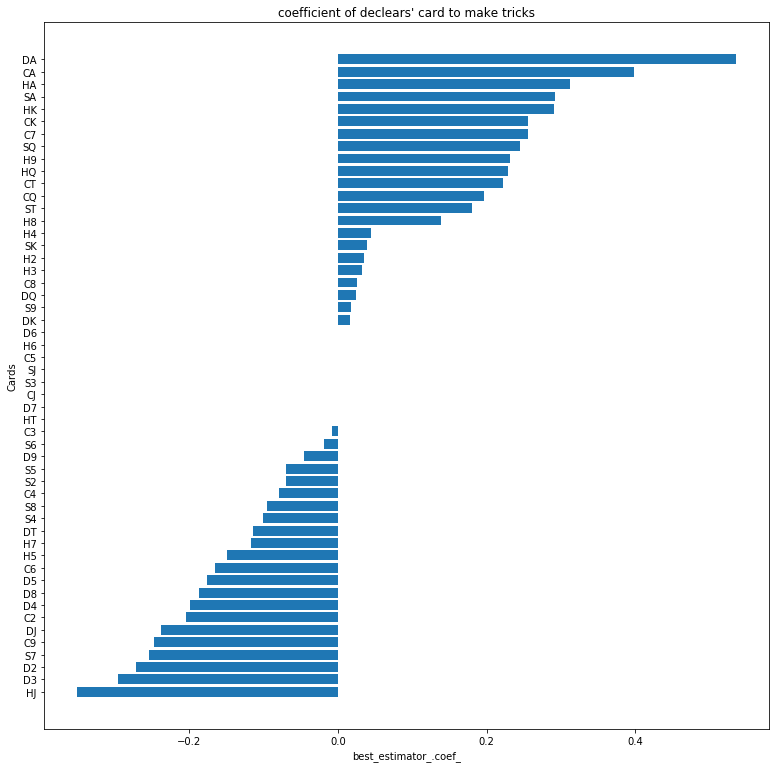

In [50]:
# Visualize the result
# Compute and print the coefficients
df_columns = just_declear.loc[:, 'SA':'C2'].columns
lasso_coef = gm_cv.best_estimator_.coef_

bar_df = pd.DataFrame({'label' : df_columns,
                       'coef'  : lasso_coef})

# sort by coef
bar_df = bar_df.sort_values(by='coef', ascending=True)


plt.figure(figsize=(13,13))
# Make  dataset
height = bar_df['coef']
bars = bar_df['label']
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('best_estimator_.coef_')
plt.ylabel('Cards')
plt.title('''coefficient of declears' card to make tricks''')
 
# Show graphic
plt.show()

#### 3.1.2 Ridge Regression

In [51]:
# Create the hyperparameter grid
alpha = np.linspace(50, 100, 50)
param_grid = {'alpha': alpha}
 
# Instantiate the Ridge regressor: ridge
ridge = Ridge()
 
# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(ridge, param_grid, cv=5)
 
# Fit it to the training data
gm_cv.fit(X_train, y_train)
 
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("Tuned Ridge alpha: {}".format(gm_cv.best_params_))
print("Tuned Ridge R squared: {}".format(r2))
print("Tuned Ridge MSE: {}".format(mse))
print("Tuned Ridge RMSE: {}".format(rmse))

Tuned Ridge alpha: {'alpha': 70.40816326530611}
Tuned Ridge R squared: 0.08491815025847249
Tuned Ridge MSE: 2.913058724143733
Tuned Ridge RMSE: 1.7067685033840216


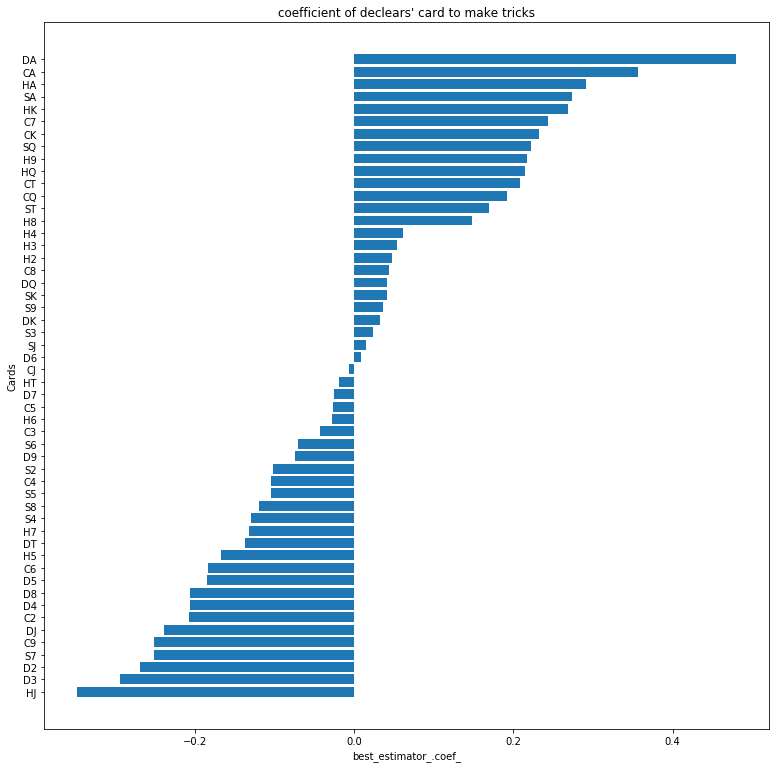

In [52]:
# Visualize the result
# Compute and print the coefficients
df_columns = just_declear.loc[:, 'SA':'C2'].columns
ridge_coef = gm_cv.best_estimator_.coef_

bar_df = pd.DataFrame({'label' : df_columns,
                       'coef'  : ridge_coef})

# sort by coef
bar_df = bar_df.sort_values(by='coef', ascending=True)


plt.figure(figsize=(13,13))
# Make  dataset
height = bar_df['coef']
bars = bar_df['label']
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('best_estimator_.coef_')
plt.ylabel('Cards')
plt.title('''coefficient of declears' card to make tricks''')

# Show graphic
plt.show()

Not suprisingly both two regression models don't perform well only on the declear data.
Let add the dummy data and see if anything changes.

#### 3.2 Model with dummies' hands
<a id="m2"></a>

In [53]:
# just get dummy's hand
just_dummy = ml_df.copy()
just_dummy = just_dummy.drop(columns=['declear','LHO','RHO'])

# split the suits: dummy
just_dummy = just_dummy['dummy'].str.split('S', expand=True)

just_dummy['dummy_S'] = just_dummy[1].str.split('H', expand=True)[0]
just_dummy['to_split'] = just_dummy[1].str.split('H', expand=True)[1]


just_dummy['dummy_H'] = just_dummy['to_split'].str.split('D', expand=True)[0]
just_dummy['to_split'] = just_dummy['to_split'].str.split('D', expand=True)[1]


just_dummy['dummy_D'] = just_dummy['to_split'].str.split('C', expand=True)[0]
just_dummy['dummy_C'] = just_dummy['to_split'].str.split('C', expand=True)[1]

just_dummy = just_dummy.drop(columns=[0, 1, 'to_split'])

In [54]:
# just dummy get_dummy values.

start_time = time.time()

# Create columns for dummy values
for rank in ALL_RANKS:
    for value in rank:
        just_dummy[value] = 0

# get dummy value of spades
for i in range(just_dummy.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_dummy.iloc[i, 0]:
            just_dummy.iloc[i, 4+j] = True


# get dummy value of hearts
for i in range(just_dummy.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_dummy.iloc[i, 1]:
            just_dummy.iloc[i, 17+j] = True


# get dummy value of diamonds
for i in range(just_dummy.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_dummy.iloc[i, 2]:
            just_dummy.iloc[i, 30+j] = True


# get dummy value of clubs
for i in range(just_dummy.shape[0]):
    for j, rank in enumerate(RANK):
        if rank in just_dummy.iloc[i, 3]:
            just_dummy.iloc[i, 43+j] = True


print("--- %s seconds ---" % (time.time() - start_time))

--- 34.39526128768921 seconds ---


In [55]:
# Change the name of columns
dummy_column_name = ['SA', 'SK', 'SQ', 'SJ',
       'ST', 'S9', 'S8', 'S7', 'S6', 'S5', 'S4', 'S3', 'S2', 'HA', 'HK', 'HQ',
       'HJ', 'HT', 'H9', 'H8', 'H7', 'H6', 'H5', 'H4', 'H3', 'H2', 'DA', 'DK',
       'DQ', 'DJ', 'DT', 'D9', 'D8', 'D7', 'D6', 'D5', 'D4', 'D3', 'D2', 'CA',
       'CK', 'CQ', 'CJ', 'CT', 'C9', 'C8', 'C7', 'C6', 'C5', 'C4', 'C3', 'C2']

dummy_column_name = ['D_' + x for x in dummy_column_name]


just_dummy.columns = ['dummy_S', 'dummy_H', 'dummy_D', 'dummy_C'] + dummy_column_name

In [56]:
# combine declear and dummy df
declear_dummy = pd.concat([just_declear.loc[:,'SA':'C2'], just_dummy.loc[:,'D_SA':'D_C2']], axis=1)

In [57]:
# build another model using both declear and dummy data

X = declear_dummy
y = df['Offense_Trick_taken']


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Create the hyperparameter grid
alpha = np.linspace(0.002, 0.003, 50)
param_grid = {'alpha': alpha}
 
# Instantiate the Lasso regressor: lasso
lasso = Lasso()
 
# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(lasso, param_grid, cv=5)
 
# Fit it to the training data
gm_cv.fit(X_train, y_train)
 
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("Tuned Lasso alpha: {}".format(gm_cv.best_params_))
print("Tuned Lasso R squared: {}".format(r2))
print("Tuned Lasso MSE: {}".format(mse))
print("Tuned Lasso RMSE: {}".format(rmse))

Tuned Lasso alpha: {'alpha': 0.002346938775510204}
Tuned Lasso R squared: 0.41368287950763327
Tuned Lasso MSE: 1.866473696803792
Tuned Lasso RMSE: 1.366189480564022


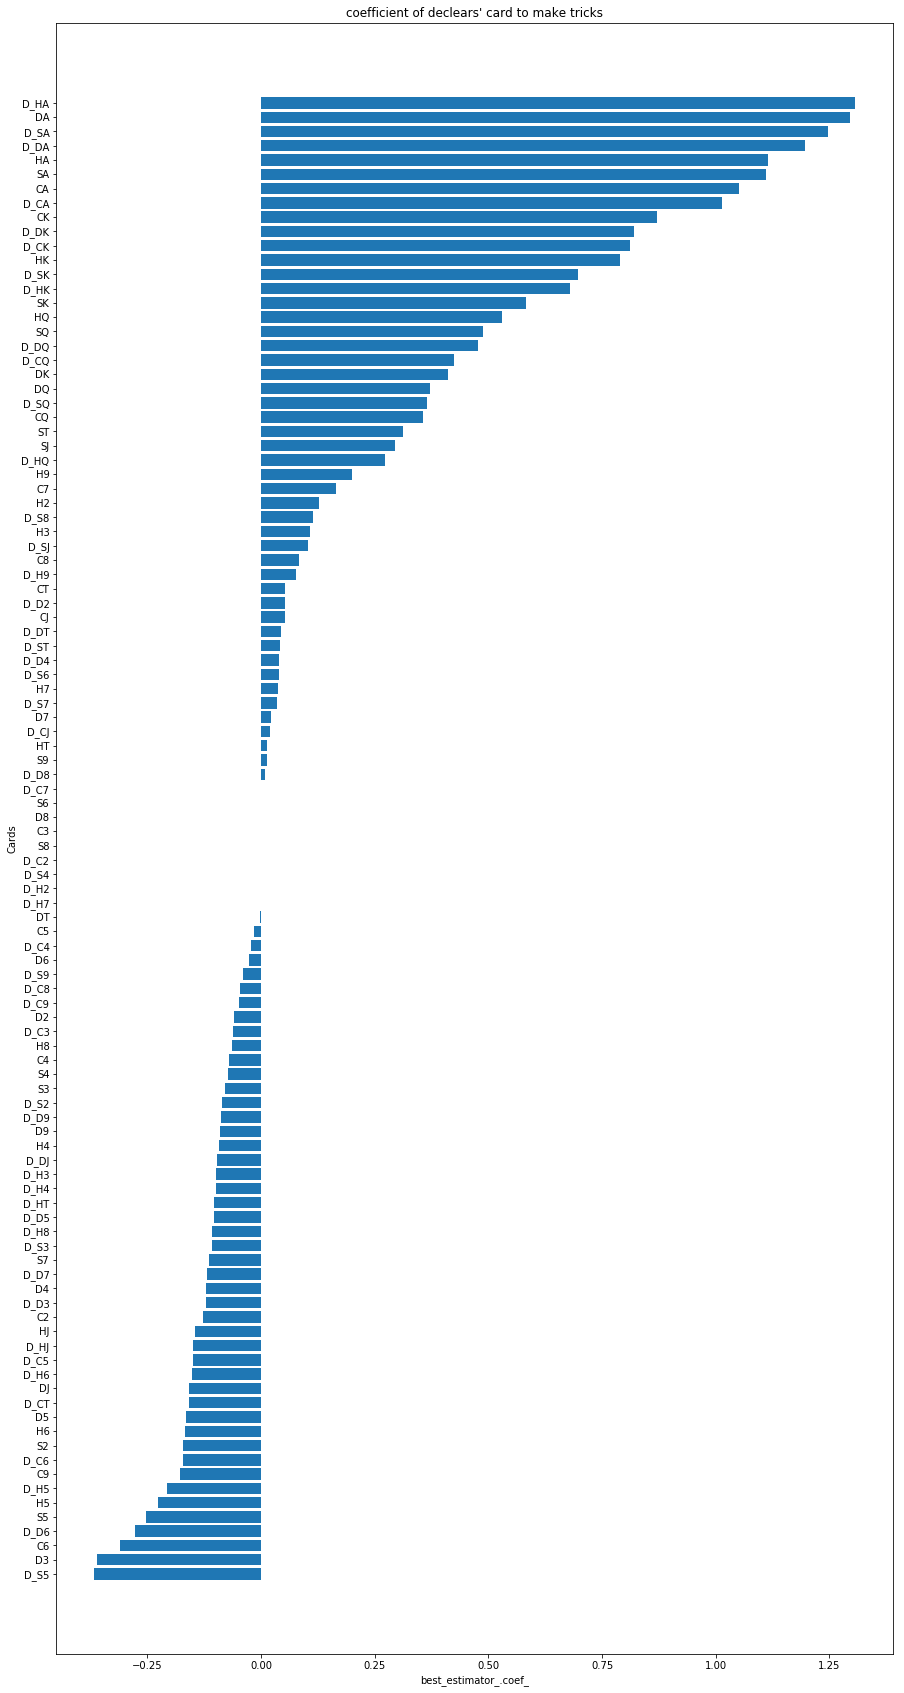

In [58]:
# Visualize the result
# Compute and print the coefficients
df_columns = declear_dummy.columns  # label
lasso_coef = gm_cv.best_estimator_.coef_  # value

bar_df = pd.DataFrame({'label' : df_columns,
                       'coef'  : lasso_coef})

# sort by coef
bar_df = bar_df.sort_values(by='coef', ascending=True)


plt.figure(figsize=(15,30))
# Make fake dataset
height = bar_df['coef']
bars = bar_df['label']
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('best_estimator_.coef_')
plt.ylabel('Cards')
plt.title('''coefficient of declears' card to make tricks''')

# Show graphic
plt.show()


By contract to our first model, with dummies' data, our performance is improved.  
RMSE score is reduce from 1.7 to 1.3, which means our prediction is about 1.3 tricks away from the true result.  
However, in real game, we can not see the dummy before we bid, so we have to try another way to improve our model.  

#### 3.3 Model in Practical
<a id="m3"></a>

This time, we will try to build a practical model, which can be applied in real world bridge.  
We add the following columns into the model. These information are we can use in the real world.  

'Declar_HCP', 'Trump_fit', 'Free_run'

In [59]:
# Create the dataframe

practical_df = df[['Declar_HCP', 'Trump_fit', 'Free_run']]
practical_df = pd.concat([practical_df, just_declear.loc[:,'SA':]], axis=1)

In [60]:
# build another model using both declear and dummy data

X = practical_df
y = df['Offense_Trick_taken']


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Create the hyperparameter grid
alpha = np.linspace(0.001, 0.01, 50)
param_grid = {'alpha': alpha}
 
# Instantiate the Lasso regressor: lasso
lasso = Lasso()
 
# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(lasso, param_grid, cv=5)
 
# Fit it to the training data
gm_cv.fit(X_train, y_train)
 
# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print("Tuned Lasso alpha: {}".format(gm_cv.best_params_))
print("Tuned Lasso R squared: {}".format(r2))
print("Tuned Lasso MSE: {}".format(mse))
print("Tuned Lasso RMSE: {}".format(rmse))

Tuned Lasso alpha: {'alpha': 0.009816326530612245}
Tuned Lasso R squared: 0.5225296481049249
Tuned Lasso MSE: 1.5199724205007432
Tuned Lasso RMSE: 1.23287161557915


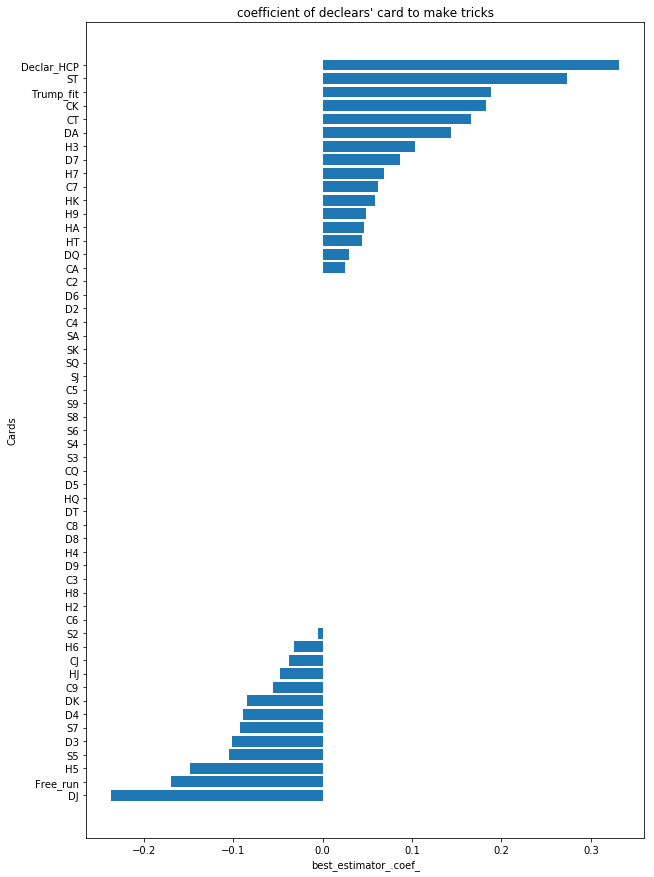

In [61]:
# Visualize the result
# Compute and print the coefficients
df_columns = practical_df.columns  # label
lasso_coef = gm_cv.best_estimator_.coef_  # value

bar_df = pd.DataFrame({'label' : df_columns,
                       'coef'  : lasso_coef})

# sort by coef
bar_df = bar_df.sort_values(by='coef', ascending=True)


plt.figure(figsize=(10,15))
# Make fake dataset
height = bar_df['coef']
bars = bar_df['label']
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('best_estimator_.coef_')
plt.ylabel('Cards')
plt.title('''coefficient of declears' card to make tricks''')

# Show graphic
plt.show()

We get a even lower RMSE 1.23 with this model.  
However, this model doesn't capture the nature of game, which is Aces, Kings, Queens are the key to win a trick.  
We still have the bidding data untouched.  We may deal with the bidding data with 2 approchs.  
One simple approach is count how many bid are made as a parameter.  
The hard one is to calculate all possible biddings and add them to the parameter.  
The previous one is too simple, and the latter one has computational problems.  

The end.